# Final Project: Prediction of Wikipedia Web Traffic
Zoe Aldington

-----

## Contents

* Problem Statement
* Obtaining the Data
* Exploratory Analysis
* Time Series Analysis
* Augmented Dickey-Fuller Test
* Model Fitting
* Final Model
* Recommendations for Future Improvements

-----

## Problem Statement
The aim is to build a predictive machine learning model which will use historic Wikipedia web traffic data to predict future daily web traffic to the site

* The model will use historic web traffic as a continuous feature.
* The model will predict traffic for the group of Wikipedia projects including DE, FR, EN and CA, for human users (excluding spiders/bots).
* The model will use daily pageview data from 1st May 2015 to 30th April 2017 as the training set (i.e. 2 years timeseries). The test set will be the daily pageview data for May 2017.
* The target variable is the future daily web traffic to the site. This is a continuous variable.

The null hypothesis is that there is no relationship between historic web traffic data and the future web traffic data i.e. the historic data cannot be used to predict the future data


In [1]:
import pandas as pd
import requests
import json
import ast
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.tsa.statespace
from statsmodels.tsa.stattools import adfuller
import operator
from itertools import product
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")
import itertools

%matplotlib inline

/Users/zoealdington/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


----

## Obtaining the Data

The dataset will be obtained using the public Wikimedia API which sources pageview data from Wikipedia.

The pageviews can be filtered for particular articles, agents or access. Additionally, the time ranges, domain and granularities can be specified.

The data can be obtained back to 1st May 2015.

I will import the pageview data for the English, German, Catalan and French Wikipedia websites from human users (not web crawlers) using mobile and desktop for the dates 1st May 2015 to 31st May 2017 (inclusive).


In [2]:
#create an empty dataframe which will hold the data
df = pd.DataFrame()

#create lists of variables which the data import will loop through
access = ['mobile-web','desktop']
agents = ['user']
projects = ['en.wikipedia','de.wikipedia','ca.wikipedia','fr.wikipedia']

#loop for requesting the data from the API using the variables above and appending to dataframe df
for access_type, agent, project in product(access,agents,projects):
    r = requests.get(url='http://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{0}/{1}/{2}/daily/2015050100/2017053100'.format(project,access_type,agent))
    x = r.json()
    a = pd.DataFrame(pd.read_json(json.dumps(x)))
    b = a['items'].apply(pd.Series)
    df = df.append(b)
df.head()

,access,agent,granularity,project,timestamp,views
0,mobile-web,user,daily,en.wikipedia,2015070100,98331028
1,mobile-web,user,daily,en.wikipedia,2015070200,97624407
2,mobile-web,user,daily,en.wikipedia,2015070300,99898208
3,mobile-web,user,daily,en.wikipedia,2015070400,108036097
4,mobile-web,user,daily,en.wikipedia,2015070500,114695926


-----

## Exploratory Analysis

Explatory data analysis is used to answer initial questions about the data set, test business assumptions, generate hypotheses for further analysis and to prepare the data for modeling.

In this section I will summarise the data with basic statistics, visualise the data and identify patterns in the data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5608 entries, 0 to 700
Data columns (total 6 columns):
access         5608 non-null object
agent          5608 non-null object
granularity    5608 non-null object
project        5608 non-null object
timestamp      5608 non-null object
views          5608 non-null int64
dtypes: int64(1), object(5)
memory usage: 306.7+ KB


In [4]:
#ask pandas to show numbers as float rather than the scientific notation
pd.set_option('display.float_format', lambda x: "{:,}".format(x))

In [5]:
df.describe()

,views
count,"5,608.0"
mean,"38,448,407.23787446"
std,"51,838,488.00605122"
min,"79,304.0"
25%,"5,649,047.5"
50%,"13,023,307.5"
75%,"44,859,768.25"
max,"187,711,730.0"


In [6]:
#check each column for nulls to see if we are missing any data
for col in df.columns:
    print(col,'nulls',df[col].isnull().sum())

access nulls 0
agent nulls 0
granularity nulls 0
project nulls 0
timestamp nulls 0
views nulls 0


In [7]:
#check the average daily page views per access, agent and project
for access_type,agent,project in product(access,agents,projects):
    print(' '.join([access_type,agent,project])
          ,'average daily views'
          ,"{:,}".format(round(df[(df.access==access_type)
                                &(df.agent==agent)
                                &(df.project==project)]['views'].mean())))

mobile-web user en.wikipedia average daily views 111,253,298
mobile-web user de.wikipedia average daily views 13,387,432
mobile-web user ca.wikipedia average daily views 141,586
mobile-web user fr.wikipedia average daily views 9,766,029
desktop user en.wikipedia average daily views 140,375,163
desktop user de.wikipedia average daily views 18,875,921
desktop user ca.wikipedia average daily views 348,768
desktop user fr.wikipedia average daily views 13,439,060


We can see from above that the English Wikipedia website receives the most page views by far.

The Catalan Wikipedia website receives the least page views by far.

In [8]:
#check if there are any datatypes we need to change
df.dtypes

access         object
agent          object
granularity    object
project        object
timestamp      object
views           int64
dtype: object

In [9]:
#format the timestamp into a datetime data type
df['date'] = df.timestamp.apply(lambda x: datetime.strptime(x,'%Y%m%d%H'))

#get the weekday number from the date to create new column
df['day_of_week_int'] = df.date.apply(lambda x: x.weekday())

#get the weekday name from the date to create new column
df['day_of_week'] = df['date'].apply(lambda x: x.strftime("%A"))

#get the month name from the date to create new column
df['month_name'] = df['date'].apply(lambda x: x.strftime("%B"))

#get the year and month from the date to create new columns
df['year'] = df.date.apply(lambda x: x.year)
df['month'] = df.date.apply(lambda x: x.month)

In [10]:
#set the date as the index to make the dataframe easier to work with
df.set_index(df.date,inplace=True)

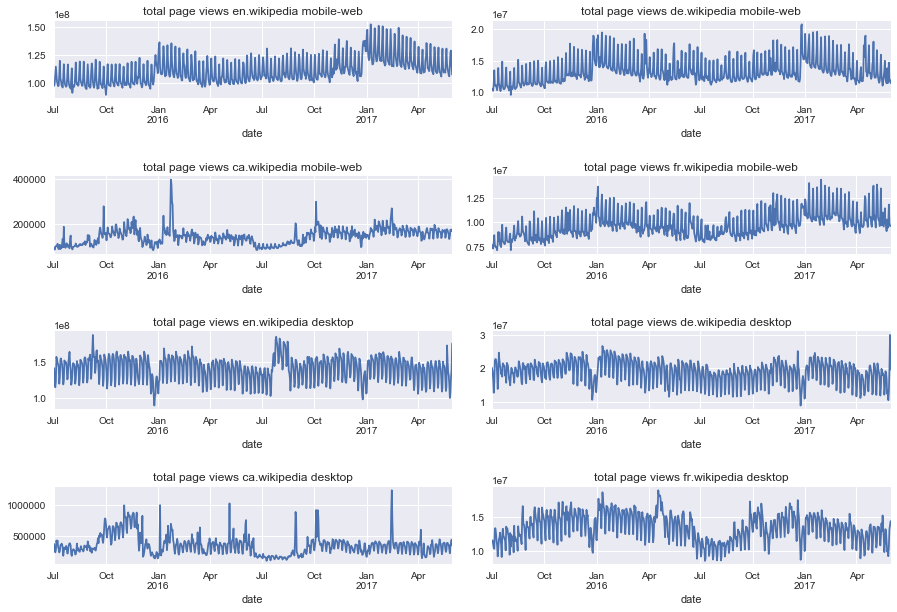

In [11]:
#plot the time series for each project and access
fig, axes = plt.subplots(4,2, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace= 0.1)

for ax,params in zip(axes.flatten(),product(access,projects)):
    df[(df.project==params[1])
        &(df.access==params[0])]\
      [['date','views']]\
        .groupby('date')\
        .agg(sum)\
        .plot(title=' '.join(['total page views'
                             ,params[1]
                             ,params[0]])
             ,legend=False
             ,ax=ax)

plt.show()

From the above graphs we can see that the Catalan wikipedia page has the lowest volume of page views over time whilst the English wikipedia has the highest volume. 

We can also see that page views from desktop are greater than page views from mobile devices for every project.

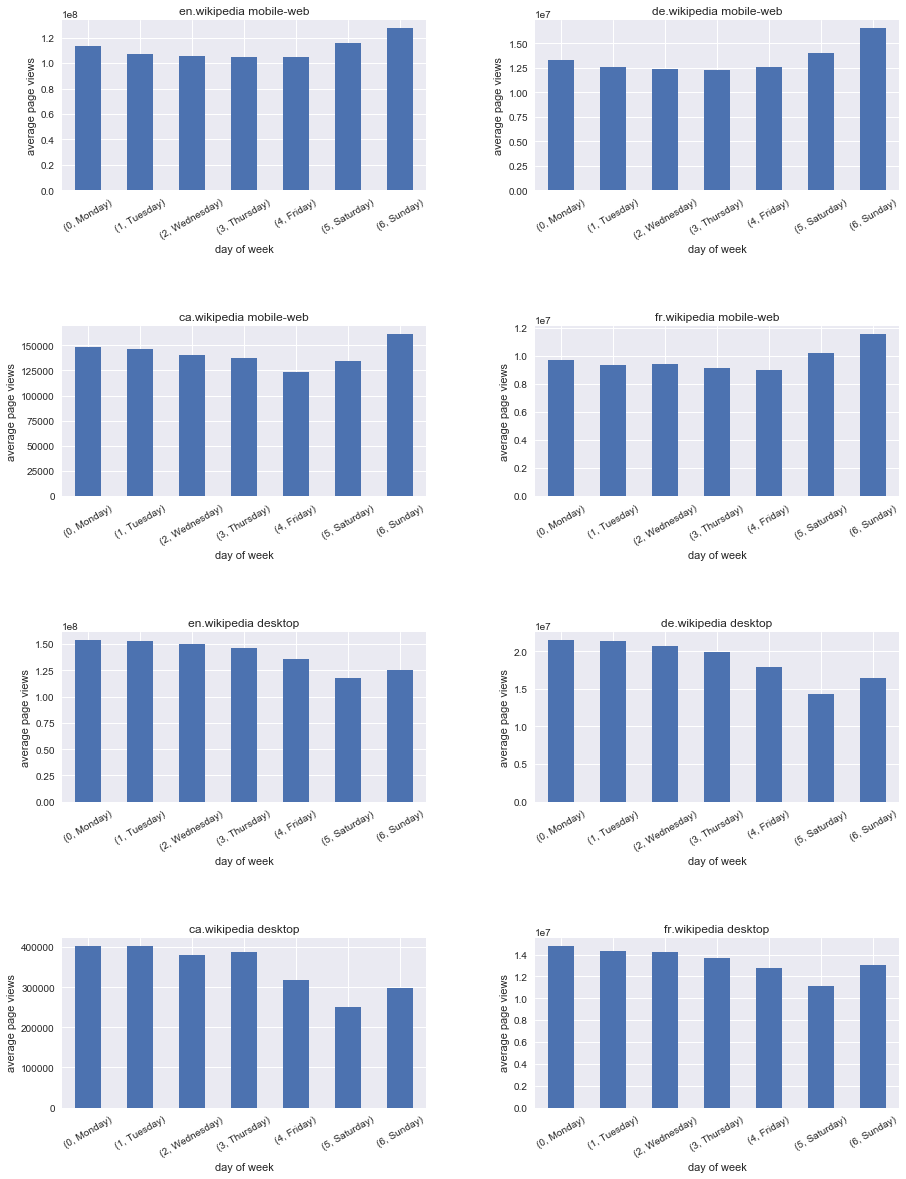

In [12]:
#plot the average page views per day of the week for each project and access
fig, axes = plt.subplots(4,2, figsize=(15, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.8, wspace= 0.3)

for ax,params in zip(axes.flatten(),product(access,projects)):
    df[(df.project==params[1])
        &(df.access==params[0])]\
      [['day_of_week_int','day_of_week','views']]\
        .groupby(['day_of_week_int','day_of_week'])\
        .agg(np.mean)\
        .plot(kind='bar'
             ,legend=False
             ,title=' '.join([params[1],params[0]])
             ,rot=30
             ,ax=ax)
    ax.set_xlabel("day of week")
    ax.set_ylabel("average page views")

plt.show()

Two main patterns can be identified from the above graphs:

* The largest daily average page views on mobile for each project comes on Sunday, closely followed by Monday, and dips in the middle of the week around Thursday/Friday.
* The largest daily average page views on desktop for each project comes on Monday, closely followed by Tuesday and dip later in the week on the Saturday.

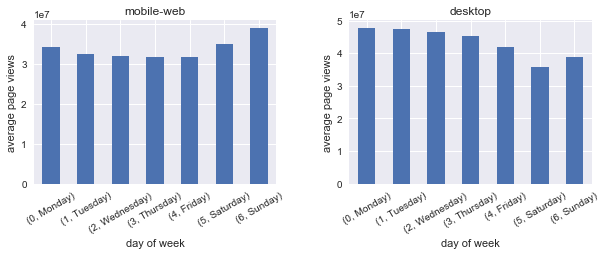

In [13]:
#plot the average page views per day of the week for each access to confirm the trends seen above
fig, axes = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.8, wspace= 0.3)

for ax,access_type in zip(axes.flatten(),access):
    df[df.access==access_type]\
       [['day_of_week_int','day_of_week','views']]\
       .groupby(['day_of_week_int','day_of_week'])\
       .agg(np.mean)\
       .plot(kind='bar'
             ,legend=False
             ,title=access_type
             ,rot=30
             ,ax=ax)
    ax.set_xlabel("day of week")
    ax.set_ylabel("average page views")

plt.show()

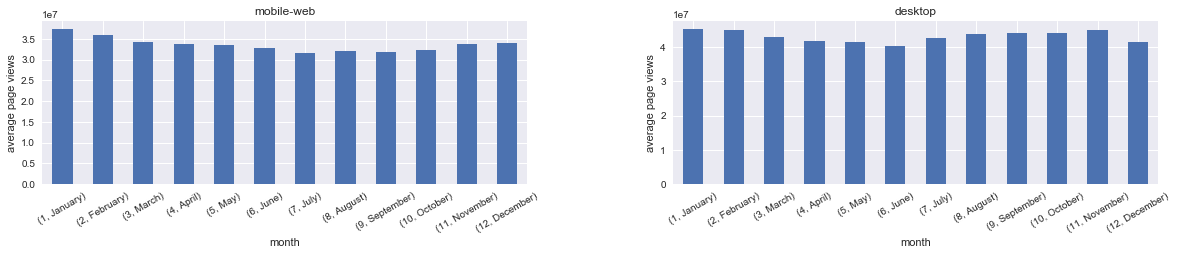

In [14]:
#plot the average page views per day of the week for each access to confirm the trends seen above
fig, axes = plt.subplots(1,2, figsize=(20, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.8, wspace= 0.3)

for ax,access_type in zip(axes.flatten(),access):
    df[df.access==access_type]\
       [['month','month_name','views']]\
       .groupby(['month','month_name'])\
       .agg(np.mean)\
       .plot(kind='bar'
             ,legend=False
             ,title=access_type
             ,rot=30
             ,ax=ax)
    ax.set_xlabel("month")
    ax.set_ylabel("average page views")

plt.show()

For both access types there appears to be some level of seasonality. For mobile users there is a peak in January which reduces into the Summer. For desktop users there is a trough in June. However, we only have two years worth of data so it may not be representative of the longer time series.

---

## Create Dummy Columns

Now I will create dummy columns for use in the model build.

Note that I couldn't use the get_dummies function because the index isn't unique (there are multiple values for each date due to the multiple values for access and project) so I would not be able to join back the dummy variables to their correct row. Pandas would attempt to join every dummy variable with a particular date back to every row in the data frame with the index with the same date, resulting in a costly function which would crash my laptop!

Next time I will create the dummy columns before setting the date as the index.

In [15]:
df.columns

Index(['access', 'agent', 'granularity', 'project', 'timestamp', 'views',
       'date', 'day_of_week_int', 'day_of_week', 'month_name', 'year',
       'month'],
      dtype='object')

In [16]:
#dummy columns for access (mobile or desktop)
for access in df.access.unique():
    df[access] = np.where(df.access==access,1,0)

In [17]:
#dummy columns for project (en, de, fr or ca)
for project in df.project.unique():
    df[project] = np.where(df.project==project,1,0)

In [18]:
#dummy columns for day of the week (mon-sun)
for day in df.day_of_week.unique():
    df[day] = np.where(df.day_of_week==day,1,0)

In [19]:
#dummy columns for month of the year (jan-dec)
for month in df.month_name.unique():
    df[month] = np.where(df.month_name==month,1,0)

In [20]:
df.columns

Index(['access', 'agent', 'granularity', 'project', 'timestamp', 'views',
       'date', 'day_of_week_int', 'day_of_week', 'month_name', 'year', 'month',
       'mobile-web', 'desktop', 'en.wikipedia', 'de.wikipedia', 'ca.wikipedia',
       'fr.wikipedia', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday', 'Tuesday', 'July', 'August', 'September', 'October',
       'November', 'December', 'January', 'February', 'March', 'April', 'May',
       'June'],
      dtype='object')

-----

## Time Series Analysis

In this section I will continue with the exploratory analysis using time series analysis techniques.

### Boxplots

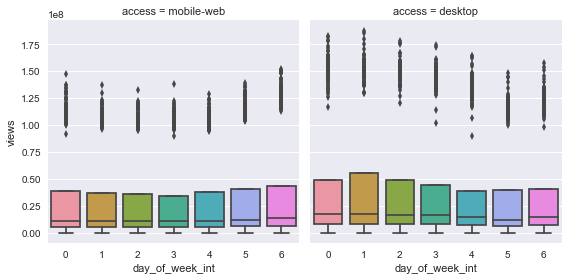

In [21]:
#view the spread of the data by day of week and access type
sb.factorplot(
    col='access',
    x='day_of_week_int',
    y='views',
    data=df, 
    kind='box'
)

There are more views from desktop than mobile and these graphs reinforce the story we saw earlier that desktop views peak on a Monday/Tuesday (day 0/1) and mobile views peak on a Saturday/Sunday (day 5/6).

Additionally, there is a large amount of outliers for every single day. We could hypothesise that these have been caused by external events e.g. a new president has been elected so more people are using Wikipedia to learn more about him/her.

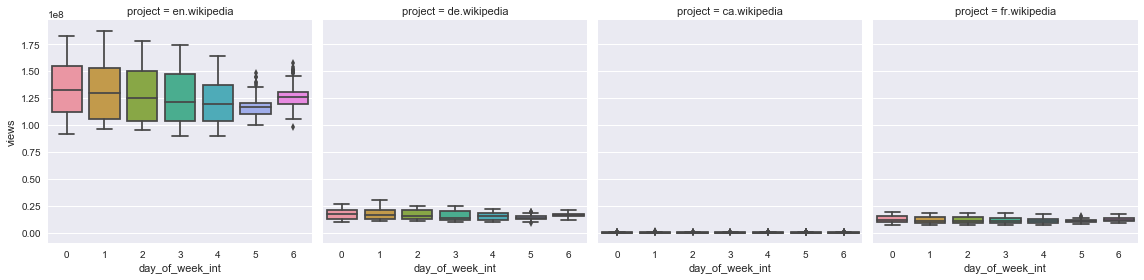

In [22]:
#view the spread of the data by day of week and project
sb.factorplot(
    col='project',
    x='day_of_week_int',
    y='views',
    data=df, 
    kind='box'
)

Again, this reinforces the story we saw earlier that Catalan Wikipedia is much less popular than English Wikipedia.

Interestingly, we can also see a general trend that Saturdays have fewer page views and less of a variance than other weekdays (the box plot shows that the median, upper quartile and lower quartile are much closer together than on other days).

There are also fewer outliers than above. This is because of the massive difference between the page views for English Wikipedia and the other projects. When the projects were grouped together, the English entries may have been viewed as outliers, however, we can see now that the projects are separated out that the English entries were not outliers and were actually consistent with what we would expect to see for this particular project.

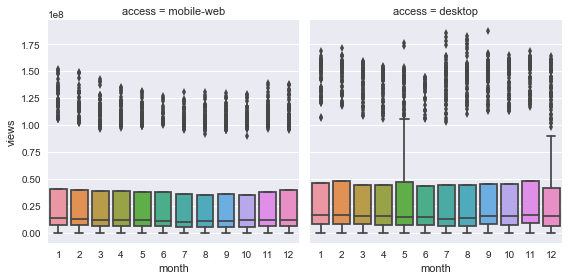

In [23]:
#view the spread of the data by month and access type
sb.factorplot(
    col='access',
    x='month',
    y='views',
    data=df, 
    kind='box'
)

As we split the boxplots by month, we can see the minor seasonality again.

Additionally, we again see a large amount of outliers. As we have not separated the boxplots by project, these will be caused by the massive amount of page views for the English Wikipedia.

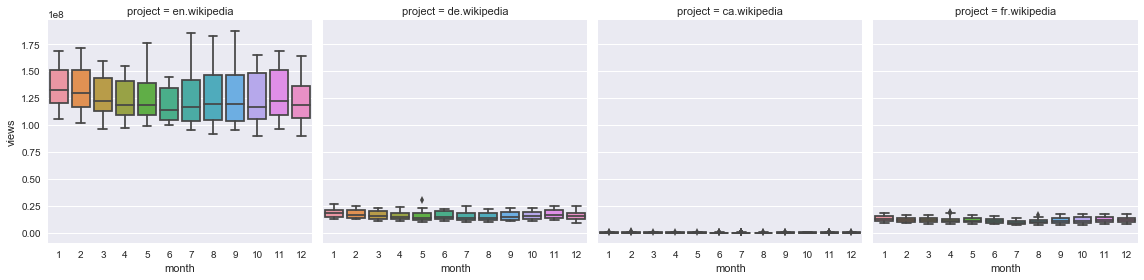

In [24]:
#view the spread of the data by month and project
sb.factorplot(
    col='project',
    x='month',
    y='views',
    data=df, 
    kind='box'
)

Now we have split the boxplots by month and project, we can see again the massive difference between the English page views and the other projects.

For the English Wikipedia, the months later in the year (August-November) have a much larger interquartile range than the other months of the year. It may be interesting to look into this later and hypothesise why this is the case.

Due to the difference in scales, it would be useful to view the other projects as boxplots separately.

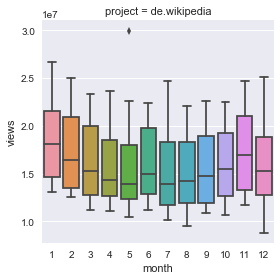

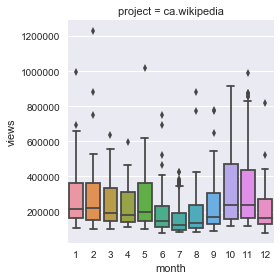

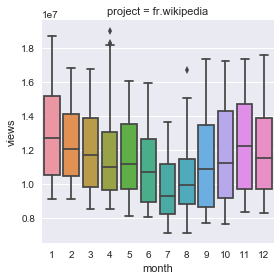

In [25]:
#take a closer look at the page views per project
for project in ['de.wikipedia','ca.wikipedia','fr.wikipedia']:
    sb.factorplot(
        col='project',
        x='month',
        y='views',
        data=df[df.project==project], 
        kind='box'
    )

We can see clearly that there is seasonality here. The Summer months show less page views, and these increase in the Winter, except for December during which time the Christmas period may be skewing the data.

### Autocorrelation

In this section I will calculate autocorrelation with various time lags to understand how correlated the page view variable is with itself earlier in time.

In [26]:
#calculate daily autocorrelation
print('daily autocorrelation 1 day lag:',
      df['views'][df.agent=='user'].resample('D').sum().autocorr(lag=1))
print('daily autocorrelation 7 day lag:',
      df['views'][df.agent=='user'].resample('D').sum().autocorr(lag=7))
print('daily autocorrelation 30 day lag:',
      df['views'][df.agent=='user'].resample('D').sum().autocorr(lag=30))
print('\n')

#calculate monthly autocorrelation
print('monthly autocorrelation 1 month lag:',
      df['views'][df.agent=='user'].resample('M').sum().autocorr(lag=1))
print('monthly autocorrelation 6 month lag:',
      df['views'][df.agent=='user'].resample('M').sum().autocorr(lag=6))
print('monthly autocorrelation 12 month lag:',
      df['views'][df.agent=='user'].resample('M').sum().autocorr(lag=12))

daily autocorrelation 1 day lag: 0.687714440938
daily autocorrelation 7 day lag: 0.8121102134
daily autocorrelation 30 day lag: -0.0240179162316


monthly autocorrelation 1 month lag: -0.0424141677871
monthly autocorrelation 6 month lag: -0.308082564605
monthly autocorrelation 12 month lag: 0.810892441708


The daily page views are positively correlated with the same day 7 days ago i.e. the same day of the week in the previous week. The daily page views are also positively correlated with the previous day, to a lesser extent. There is no correlation with the day 30 days previous.

The monthly autocorrelation shows strong positive correlation between the total page views in a particular month and the total page views in the same month in the previous year. There is slightly negative correlation of any month with the month 6 months previous and there is no correlation with the previous month.

In [27]:
#create a dataframe which totals the page views by day
daily_user_views = pd.DataFrame(df['views'].resample('D').sum())

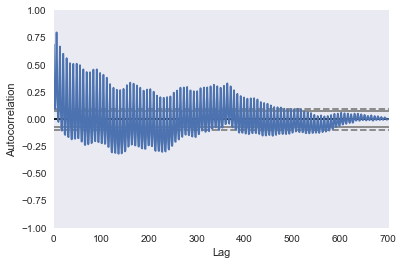

In [28]:
#plot the daily autocorrelation with various lags
autocorrelation_plot(daily_user_views)

The daily autocorrelation shows some strong positive values with smaller lags, however as the lag gets larger the autocorrelation pivots around 0 and eventually appears to converge to 0. This means that as time goes on, the earlier points have less significance for helping us to predict the future points.

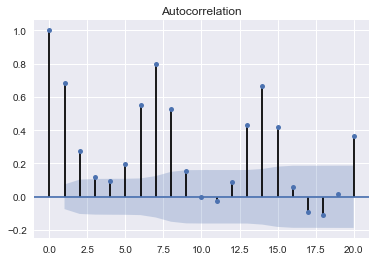

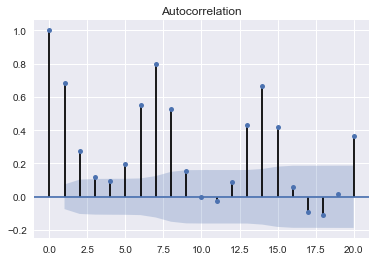

In [29]:
#plot autocorrelation for daily page views with lags 1 up to 20
plot_acf(daily_user_views,lags=20)

For each data point in the time series, there is strong positive correlation with the data point 1 day previous. We also see a strong positive correlation around the 6-8 day lag, especially for the 7 day lag and again around the 14 day lag. I will plot the same graph with more lags, to see if the weekly trend continues.

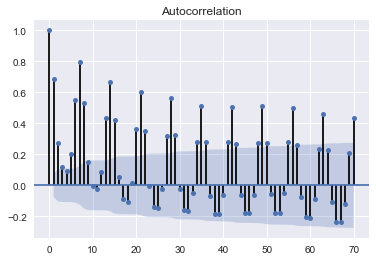

In [30]:
plot_acf(daily_user_views,lags=70)
plt.show()

The autocorrelation does appear to show a weekly trend. Although the strength of the positive correlation decreases over time, there are clear spikes for multiples of 7, i.e. a particular weekday is positively correlated with the same weekday in the previous weeks on a decreasing scale.

### Rolling Mean

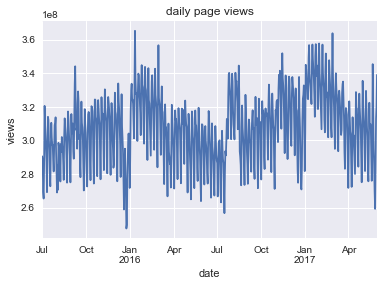

In [95]:
#plot the average daily page views across all projects and access types
ax = df['views'].resample('D').sum().plot()
ax.set_ylabel("views")
ax.set_title("daily page views")

To smooth out the data set and view the trend more easily, I'll plot the rolling mean for the daily page views with a window of 30 days, centering on each date.

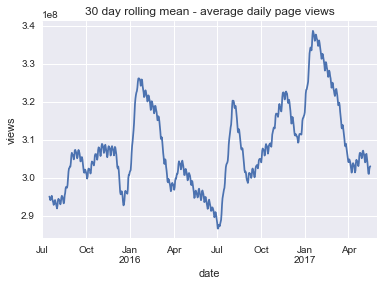

In [60]:
#plot the rolling average of daily page views across all projects and access types
ax = df['views'].resample('D').sum().rolling(window=30,center=True).mean().plot()
ax.set_ylabel("views")
ax.set_title("30 day rolling mean - average daily page views")

It looks like this time series data may not be stationary but we will check for this later before building the model.

### Rolling Mean of Difference

In order to make our time series data stationary for the model build, we might consider differencing the data. Let's take a look to see if differencing the Wikipedia page views will make our data appear more stationary.

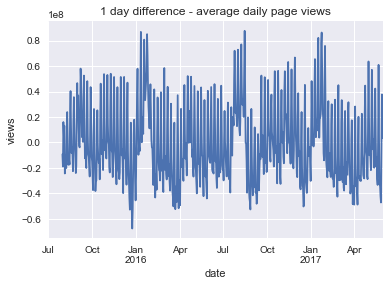

In [61]:
#plot the differences with period 30 of the average daily page views across all access types and projects
ax = df['views'].resample('D').sum().diff(periods=30).plot()
ax.set_ylabel("views")
ax.set_title("1 day difference - average daily page views")

Again, let's smooth out the data by taking the rolling mean.

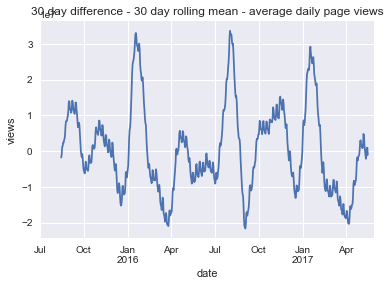

In [62]:
#plot the rolling mean (window 30) of differences with period 30 of the average daily page views 
#across all access types and projects
ax = df['views'].resample('D').sum().diff(periods=30).rolling(window=30
                                                               ,center=True).mean().plot()
ax.set_ylabel("views")
ax.set_title("30 day difference - 30 day rolling mean - average daily page views")

This appears more stationary so we might consider using differencing in our model later.

### Expanding Mean

In this section I will check if the mean page views becomes constant/more stable over time. This will also give me some insight as to whether the data is stationary.

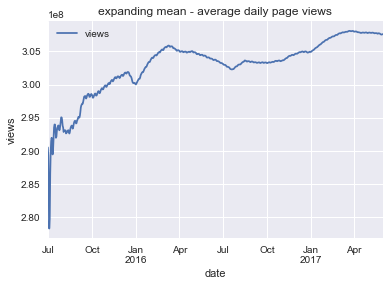

In [65]:
#plot the expanding mean of the daily user views
ax = daily_user_views.expanding().mean().plot()
ax.set_ylabel("views")
ax.set_title("expanding mean - average daily page views")

The expanding mean appears to stabilise over time to some extent but it is difficult to tell whether the variable is time-dependent i.e. whether it is growing naturally over time.

---

## Augmented Dickey-Fuller Test

The augmented Dickey-Fuller test is a type of statistical test called a unit root test. Its purpose is to determine how strongly a time series is defined by a trend. It uses an autoregressive model and optimises an information criterion across multiple different lag values. It can help to determine whether our data set is time dependent or stationary.

The null hypothesis of the test is that the time series can be represented by a unit root, that is is **not** stationary (i.e. the data has some time-dependent structure). 

The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary (the data is not time dependent).

We interpret this result using the p-value from the test. We will use a 95% confidence level. This means that:

* If p > 0.05 then accept the null hypothesis - the data has a unit root and is non-stationary
* If p < 0.05 then reject the null hypothesis - the data does not have a unit root and is stationary

In [36]:
daily_user_views = pd.DataFrame(df['views'].resample('D').sum())
daily_user_views = pd.DataFrame(daily_user_views)[['views']].astype(float)

In [37]:
#run the adfuller test and print the results
adfuller_result = adfuller(daily_user_views.views)
print('ADF Statistic: {}'.format(adfuller_result[0]))
print('ADF p-value: {}'.format(adfuller_result[1]))
print('Critical values: ')
for key, value in adfuller_result[4].items():
    print('\t{}: {}'.format(key,value))

ADF Statistic: -3.0446630574525635
ADF p-value: 0.03092875036854114
Critical values: 
	1%: -3.4400031721739515
	5%: -2.865799725091594
	10%: -2.569038427768166


Our test gave us a p-value of 0.03. This is less than 0.05 so we can say with 95% confidence that the data **is stationary**. This means that we **don't** need to transform the data into a stationary format before building the model.

I'll run the augmented dickey-fuller test on the differenced data to show that the differencing should make the data set more stationary:

In [38]:
daily_user_views_diff = pd.DataFrame(df['views']\
                                     .resample('D')\
                                     .sum()\
                                     .diff(periods=1)\
                                     .astype(float))['2015-07-02':] #filtering on date here because days before 
                                                                    #won't have a difference (no data -30days)

In [39]:
#run the adfuller test for the differenced data
adfuller_result_for_diff = adfuller(daily_user_views_diff.views, autolag='AIC')
print('ADF Statistic: {}'.format(adfuller_result_for_diff[0]))
print('ADF p-value: {}'.format(adfuller_result_for_diff[1]))
print('Critical values: ')
for key, value in adfuller_result_for_diff[4].items():
    print('\t{}: {}'.format(key,value))

ADF Statistic: -6.341824854530806
ADF p-value: 2.7427899012648134e-08
Critical values: 
	1%: -3.4400174432106305
	5%: -2.8658060125001295
	10%: -2.569041777564251


This test gave us a p-value of 0.00000003. This is far smaller than 0.05 so we can say with 95% confidence that the differenced data **is stationary**. In fact, this p-value is also less than 0.01 so we can say with 99% confidence that the differenced data is stationary. We could use differenced data in our model, but we could also use the original data in our model (albeit with a bit less confidence that we are meeting the stationarity assumption of the model).

-----

## Model Fitting

For the prediction of future data points, I'll try to use an ARMA model - this is a combination of two models; autoregressive and moving average.

Autoregressive models use the historic data points to predict the future data points. I believe that the previous data points will be able to predict the future data points to a certain extent because of the autocorrelation shown above.

Moving average models use the moving average and the previous error terms to predict the future values. I believe this is suited to the problem because the data can behave unexpectedly due to external factors e.g. an event in the news might cause a surge in the number of page views.

Since the augmented dickey-fuller test gave me 95% confidence that the data is stationary, I will not difference the data but will instead use the original data set for the model. However, I will fit some ARIMA (autoregressive integrated moving average) models too to see if these perform better as I know that the differenced data is more stationary than the original data set.

### AR(1)

Starting with a simple model, I will fit an ARMA(1,0) which is effectively an AR(1). This is a simple autoregressive model which uses the previous data point (1 period lag) to predict the next data point.

In [40]:
model = ARMA(daily_user_views, (1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  views   No. Observations:                  701
Model:                     ARMA(1, 0)   Log Likelihood              -12565.459
Method:                       css-mle   S.D. of innovations       14733772.206
Date:                Wed, 22 Nov 2017   AIC                          25136.919
Time:                        14:44:14   BIC                          25150.577
Sample:                    07-01-2015   HQIC                         25142.198
                         - 05-31-2017                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.076e+08   1.78e+06    172.854      0.000    3.04e+08    3.11e+08
ar.L1.views     0.6883      0.027     25.095      0.000       0.634       0.742
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4530           +0.0000j            1.4530            0.0000
-----------------------------------------------------------------------------
"""

In this AR(1) model we learn an intercept value, or base views values. Additionally, we learn a coefficient that tells us how to include the last views values. In this case, we take the intercept of ~307,800,000 and add in the previous day views times ~0.69.

The coefficient here approximately matches the lag 1 autocorrelation - implying the data is stationary.

We can plot the true number of views against the forecast to get some idea of how well the model fits.

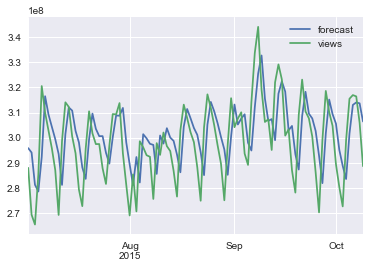

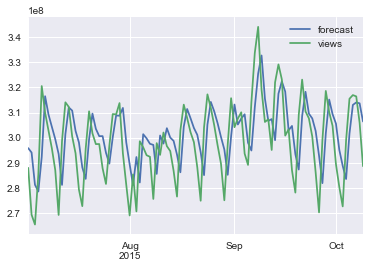

In [41]:
model.plot_predict(1,100)

There are many discrepencies between the forecast and the true values so we will try to improve the model.

First of all I will split the model into three sets:

* Train: a set of data points to train and fit the model.
* Validation: a set of data points on which to tune the parameters of the model. We use this data set to find the model which gives us the best results.
* Test: a set of unseen data points to assess the model we chose.

Why separate test and validation sets? The error rate estimate of the final model on validation data will be biased (smaller than the true error rate) since the validation set is used to select the final model After assessing the final model on the test set, you must not tune the model any further.

(source: https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set)

As in the defined problem statement, I will use May 2017 data as the test set.

I use the data previous to May 2017 for the train (75%) and validation (25%).

In [42]:
#set the train/validate data set to be all views up to the end of April 2017
train_and_validate = daily_user_views[:'2017-04-30']

#set the test data set to be all views in May
test = daily_user_views['2017-05-01':]

In [43]:
#separate the train and validation data set into 75% train and 25% validation
n = len(train_and_validate)
train = train_and_validate[:int(.75*n)]
validation = train_and_validate[int(.75*n):]

Now I'll try fitting an ARIMA(1,0,0) (equivalent to ARMA(1,0)) again using the train set and validate on the validation set.

To view the accuracy of the predictions I'll use the root mean squared error and also the symmetric mean absolute percentage error (SMAPE - I'll use the formula provided by https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error).

The root mean squared error aggregates the magnitude of the errors of the predictions into a single measure, to serve as a measure of accuracy. However, it is scale-dependent so it may be very large and difficult to interpret. For this reason, I will also use the SMAPE as this is also based on the errors but is relative, therefore it will be a smaller value and easier to interpret.

In [44]:
#create the function based on the formula in the wikipedia article
def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.abs(y_true - y_pred) / ((np.abs(y_true)+np.abs(y_pred))/2))) * 100

In [45]:
model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

#predictions for the dates in the validation set
predictions = model.predict(
    '2016-11-14',
    '2017-04-30',
    dynamic=True, 
)

print("Root mean squared error: ", math.sqrt(mean_squared_error(validation, predictions)))
print("SMAPE: ",symmetric_mean_absolute_percentage_error(validation,predictions))
model.summary()

Root mean squared error:  24869007.74004134
SMAPE:  6.64582197603


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  views   No. Observations:                  502
Model:                     ARMA(1, 0)   Log Likelihood               -8982.306
Method:                       css-mle   S.D. of innovations       14268263.160
Date:                Wed, 22 Nov 2017   AIC                          17970.611
Time:                        14:44:15   BIC                          17983.267
Sample:                    07-01-2015   HQIC                         17975.576
                         - 11-13-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.041e+08   1.83e+06    166.591      0.000       3e+08    3.08e+08
ar.L1.views     0.6524      0.034     19.237      0.000       0.586       0.719
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5328           +0.0000j            1.5328            0.0000
-----------------------------------------------------------------------------
"""

How do I interpret whether this model shows good results?

Later I will loop through several different models to compare and select the best performer.

I can also plot the residuals of the model to interpret the performance of the model.

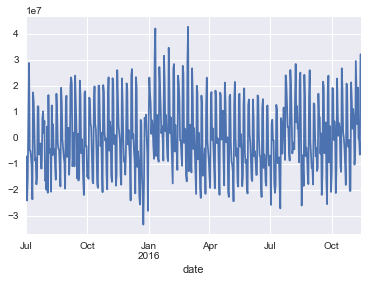

In [46]:
#plot the residuals of the model
model.resid.plot()

The residuals massively jump around, however they do centre around 0.

Now I'll plot the autocorrelation of the residuals. If any autocorrelation is revealed, this suggests that there is information that has not been accounted for in the model.

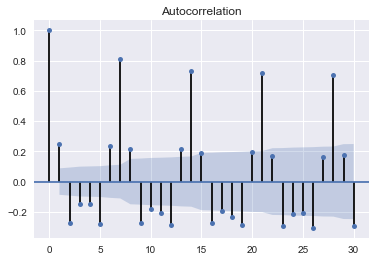

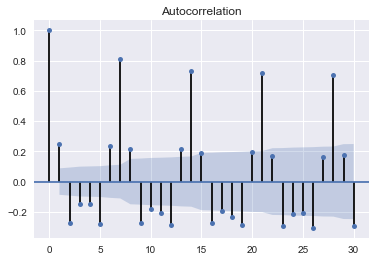

In [47]:
#plot the autocorrelation of the model residuals for lags 1-30
plot_acf(model.resid, lags=30)

We can see very strong positive autocorrelation, again, on a weekly basis. This suggests that the model is not accounting for the weekly seasonality.

### ARIMA(1,1,0) i.e. AR(1) on Differenced Series

Does the model performance improve if I introduce a degree of differencing of 1?

In [48]:
model = sm.tsa.ARIMA(train, (1, 1, 0)).fit()

predictions = model.predict(
    '2016-11-14',
    '2017-04-30',
    dynamic=True, 
)

print("Root mean squared error: ", math.sqrt(mean_squared_error(validation, predictions)))
print("SMAPE: ",symmetric_mean_absolute_percentage_error(validation,predictions))
model.summary()

Root mean squared error:  319316874.88952124
SMAPE:  199.843505138


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.views   No. Observations:                  501
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9006.756
Method:                       css-mle   S.D. of innovations       15534889.102
Date:                Wed, 22 Nov 2017   AIC                          18019.512
Time:                        14:44:15   BIC                          18032.162
Sample:                    07-02-2015   HQIC                         18024.476
                         - 11-13-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9.468e+04   8.07e+05      0.117      0.907   -1.49e+06    1.68e+06
ar.L1.D.views     0.1400      0.044      3.156      0.002       0.053       0.227
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.1416           +0.0000j            7.1416            0.0000
-----------------------------------------------------------------------------
"""

Introducing d=1 massively reduces the performance of the model.

Now I'll fit multiple models and compare their performance using SMAPE as the measure of accuracy.

### Fitting Multiple Models 

I'll loop through lists of various p, d and q values in order to find the SMAPE of multiple models.

* P values: the order of the autoregressive model (number of time lags to consider)
* D values: the degree of differencing (the number of times the data have had past values subtracted)
* Q values: the order of the moving-average model (number of previous errors to consider)

In [49]:
#set the lists of p, d and q values to loop through
p_values = [0, 1, 2, 5, 7, 10, 14]
d_values = range(0, 3)
q_values = range(0, 3)

#set an empty dictionary to put the results into
loop_results = {}

#create a cross product of the p, d and q values to produce a list to loop through
for p, d, q in itertools.product(p_values,d_values,q_values):
    params = (p, d, q)
    #try to fit the model for the set parameters
    try:
        #fit on the train data and the set parameters
        model = sm.tsa.ARIMA(train,params).fit()
        #predict the values for the dates in the validation data set
        predictions = model.predict('2016-11-14','2017-04-30',dynamic=True)
        #set the dictionary key-value pair to be parameters:SMAPE
        loop_results[params] = symmetric_mean_absolute_percentage_error(validation,predictions)
    #if the parameters don't work then continue to the next set of parameters
    except:
        continue

In [50]:
#show the results of the model fittings and order by their SMAPE values (the smaller the better!)
sorted(loop_results.items(), key=operator.itemgetter(1))

[((7, 0, 0), 5.9286338092479847),
 ((7, 0, 1), 5.9589390651583987),
 ((7, 0, 2), 6.1645835706688628),
 ((5, 0, 1), 6.2935885181283142),
 ((2, 0, 2), 6.4549942419324022),
 ((14, 0, 0), 6.6192026449130665),
 ((14, 0, 1), 6.6292276211218013),
 ((5, 0, 0), 6.6335652634395244),
 ((1, 0, 0), 6.6458219760341875),
 ((1, 0, 1), 6.6732067579506724),
 ((1, 0, 2), 6.673470851039295),
 ((2, 0, 1), 6.6776022509339823),
 ((2, 0, 0), 6.6822097906141105),
 ((0, 0, 1), 6.6827402233818809),
 ((0, 0, 0), 6.6834543437159111),
 ((10, 0, 1), 6.7661925645716634),
 ((10, 0, 0), 6.7671995004960221),
 ((14, 0, 2), 6.8117500220826468),
 ((5, 0, 2), 6.9635734699856862),
 ((10, 0, 2), 7.1121540535859982),
 ((10, 1, 2), 194.952302215994),
 ((14, 2, 0), 195.80348408176965),
 ((10, 2, 2), 195.82378251226856),
 ((14, 2, 2), 195.91907403921672),
 ((14, 2, 1), 195.96512414478485),
 ((5, 2, 2), 196.17388363324545),
 ((14, 1, 2), 196.52437346034256),
 ((14, 1, 1), 196.54942269082849),
 ((14, 1, 0), 196.58249441492035),
 ((

It looks like the best model according to SMAPE score is ARIMA(7,0,0). However, as we saw earlier, the autocorrelation of the residuals is also something we should consider when selecting the best model. So, I will plot the autocorrelation of the top few models to see which accounts for the weekly seasonality best.

### 1. ARIMA(7,0,0)

Root mean squared error:  21289157.539845787
SMAPE:  5.92863380925
                              ARMA Model Results                              
Dep. Variable:                  views   No. Observations:                  502
Model:                     ARMA(7, 0)   Log Likelihood               -8770.742
Method:                       css-mle   S.D. of innovations        9319431.047
Date:                Wed, 22 Nov 2017   AIC                          17559.484
Time:                        15:10:04   BIC                          17597.452
Sample:                    07-01-2015   HQIC                         17574.380
                         - 11-13-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.041e+08   5.66e+06     53.742      0.000    2.93e+08    3.15e+08
ar.L1.views     0.6833      0.043     15.873      0.000      

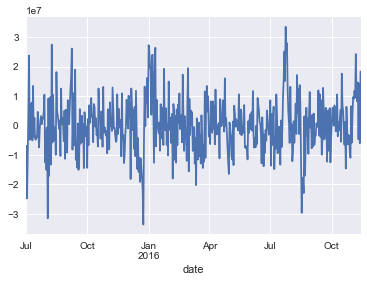

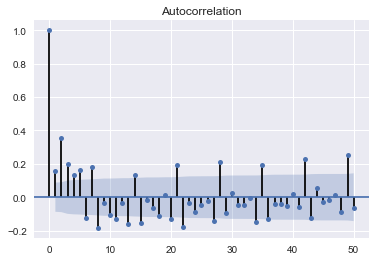

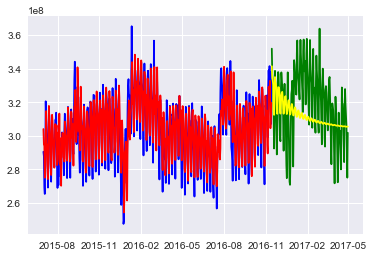

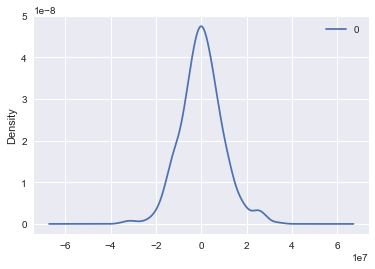

In [67]:
model = sm.tsa.ARIMA(train, (7, 0, 0)).fit()

#predict the values for the dates in the prediction set
predictions = model.predict(
    '2016-11-14',
    '2017-04-30',
    dynamic=True, 
)

print("Root mean squared error: ", math.sqrt(mean_squared_error(validation, predictions)))
print("SMAPE: ",symmetric_mean_absolute_percentage_error(validation,predictions))

print(model.summary())

model.resid.plot()

plot_acf(model.resid, lags=50)
plt.show()

#plot the training data, validation data, the values that the model fitted to the training data
#and predictions for the validation data
plt.plot(train, color='blue')
plt.plot(validation, color='green')
plt.plot(model.fittedvalues, color='red')
plt.plot(predictions,color='yellow')

#plot the distribution of the residuals
pd.DataFrame(model.resid).plot(kind='kde')

The model fits the y-intercept at 304,100,000 and the coefficients for the lag views are:
* ar.L1.views     0.6833
* ar.L2.views    -0.3841  
* ar.L3.views     0.1800  
* ar.L4.views    -0.0020  
* ar.L5.views    -0.2030  
* ar.L6.views     0.3813  
* ar.L7.views     0.2776 

We can interpret these as the feature importances. They show that the value for 1 day previous is most important as we apply a coefficient of 0.68 to this variable.

The residual autocorrelation for this model is quite low, however, we can still see some strong correlation at the weekly points.

The distribution of the residuals is normal and centres around 0 which means the amount of error across the time series in the model is consistent.

### 2. ARIMA(7,0,1)

Root mean squared error:  21238626.367040288
SMAPE:  5.95893906516


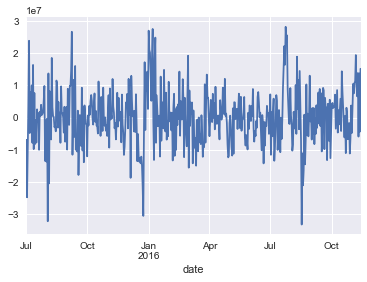

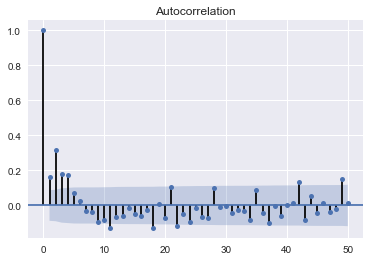

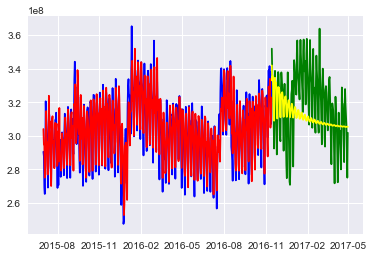

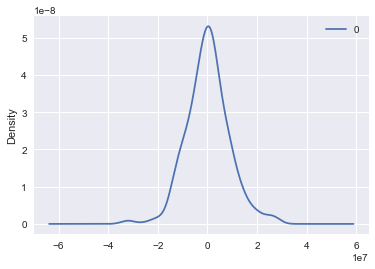

In [52]:
model = sm.tsa.ARIMA(train, (7, 0, 1)).fit()

predictions = model.predict(
    '2016-11-14',
    '2017-04-30',
    dynamic=True, 
)

print("Root mean squared error: ", math.sqrt(mean_squared_error(validation, predictions)))
print("SMAPE: ",symmetric_mean_absolute_percentage_error(validation,predictions))

model.resid.plot()

plot_acf(model.resid, lags=50)
plt.show()

plt.plot(train, color='blue')
plt.plot(validation, color='green')
plt.plot(model.fittedvalues, color='red')
plt.plot(predictions,color='yellow')

pd.DataFrame(model.resid).plot(kind='kde')

The residual autocorrelation for this model is also quite low, and lower than ARIMA(7,0,0). There is still a marginal display of the weekly seasonality but less so than for ARIMA(7,0,0) so we might consider this when we choose our final model.

### 3. ARIMA(7,0,2)

Root mean squared error:  21845101.75272344
SMAPE:  6.16458357067


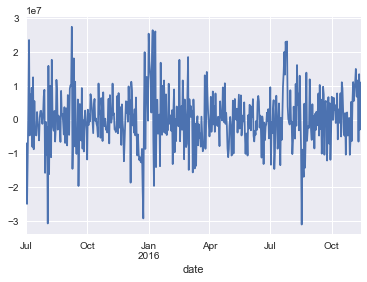

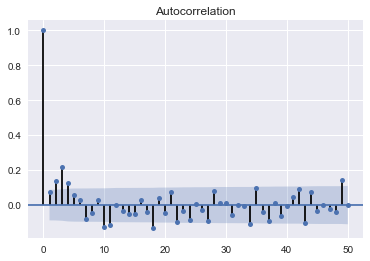

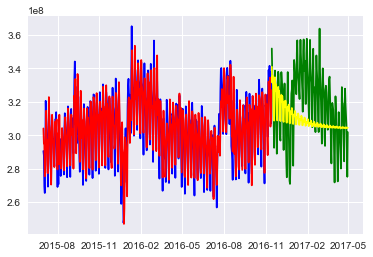

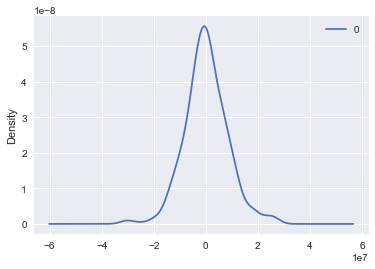

In [53]:
model = sm.tsa.ARIMA(train, (7, 0, 2)).fit()

predictions = model.predict(
    '2016-11-14',
    '2017-04-30',
    dynamic=True, 
)

print("Root mean squared error: ", math.sqrt(mean_squared_error(validation, predictions)))
print("SMAPE: ",symmetric_mean_absolute_percentage_error(validation,predictions))

model.resid.plot()

plot_acf(model.resid, lags=50)
plt.show()

plt.plot(train, color='blue')
plt.plot(validation, color='green')
plt.plot(model.fittedvalues, color='red')
plt.plot(predictions,color='yellow')

pd.DataFrame(model.resid).plot(kind='kde')

The residual autocorrelation for this model appears similar to above, but to a slightly lesser extent. However, the SMAPE has increased to over 6 so we have to consider the balance between choosing a good SMAPE score and a model which reduces the residual autocorrelation enough. In this case, I would be inclined to choose the previous model, ARIMA(7,0,1) which appears to strike a good balance between the two.

Additionally, the distribution of the residuals for the model ARIMA(7,0,2) is normal but the mean is slightly below zero which means the model errors are not consistent and the amount of predictive power that the model has is not the same across the full range of variables.

---

## Final Model

I'll select ARIMA(7,0,1) as the final version of the model. This is because it performed well in the comparison of multiple models with its SMAPE score, the autocorrelation of the residuals and the distribution of the residuals.

I'll re-train the model using the train data set with the validation data set, and finally I will use the model to predict the test data set and analyse how well it performs.

Root mean squared error:  14809000.802374411
SMAPE:  6.02178835523
                              ARMA Model Results                              
Dep. Variable:                  views   No. Observations:                  670
Model:                     ARMA(7, 1)   Log Likelihood              -11643.867
Method:                       css-mle   S.D. of innovations        8495420.166
Date:                Wed, 22 Nov 2017   AIC                          23307.735
Time:                        15:46:12   BIC                          23352.807
Sample:                    07-01-2015   HQIC                         23325.193
                         - 04-30-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.078e+08   5.48e+06     56.130      0.000    2.97e+08    3.18e+08
ar.L1.views     0.1371      0.037      3.675      0.000      

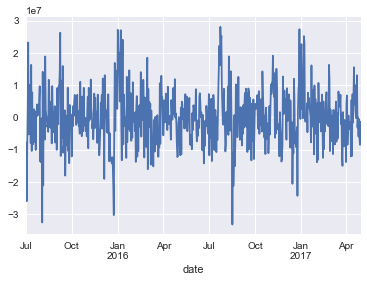

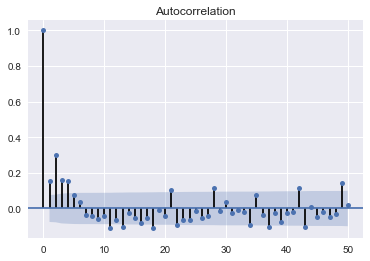

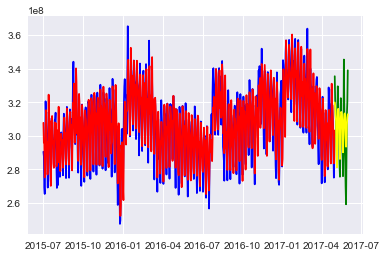

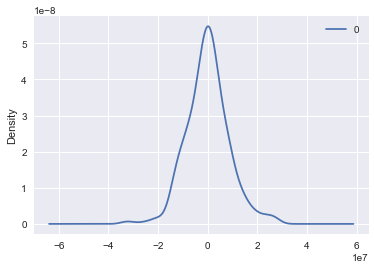

In [71]:
model = sm.tsa.ARIMA(train_and_validate, (7, 0, 1)).fit()

predictions = model.predict(
    '2017-05-01',
    '2017-05-31',
    dynamic=True, 
)

print("Root mean squared error: ", math.sqrt(mean_squared_error(test, predictions)))
print("SMAPE: ",symmetric_mean_absolute_percentage_error(test,predictions))

print(model.summary())

model.resid.plot()

plot_acf(model.resid, lags=50)
plt.show()

plt.plot(train_and_validate, color='blue')
plt.plot(test, color='green')
plt.plot(model.fittedvalues, color='red')
plt.plot(predictions,color='yellow')

pd.DataFrame(model.resid).plot(kind='kde')

The model has performed with a root mean squared error of 14,809,001 and SMAPE score 6.02. These are very strong scores when compared to the other models and the initial training of the model against the validation set.

In this model the most important feature is the 7-day lag date. This corresponds to the autocorrelation we saw in the exploratory analysis where the highest autocorrelation was for this same period.

-----

## Recommendations for Future Improvements

There are improvements that I would like to make to this model which I haven't had time to explore. These include:

* ARIMAX: ARIMA including exogenous variables
    * Using day of the week as a feature in the model
    * Obtaining external data such as a live BBC news API to use as a live feature
* SARIMAX: ARIMAX including adjustments for seasonality
    * Seasonal decomposition
* Outlier analysis
* Predict on per-article basis rather than aggregated page view data set
* Natural language processing on the content of the article to use as a feature

-----

### Future Improvements Playground

In [55]:
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = df[col].astype(float)

### ARIMAX

Root mean squared error:  22047700.569964148
SMAPE:  5.79380577878


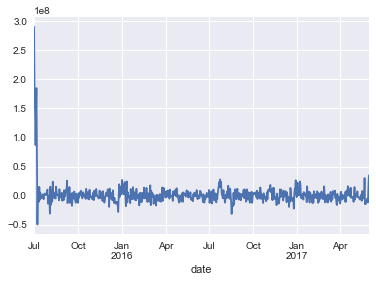

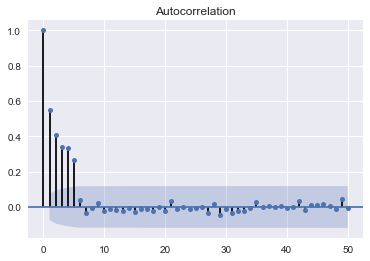

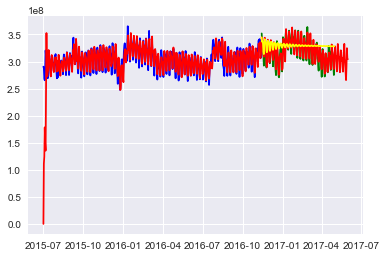

In [56]:
model = sm.tsa.statespace.SARIMAX(daily_user_views
                                  , exog=None
                                  , order=(7, 0, 2)
                                  , enforce_stationarity=False).fit()

predictions = model.predict(
    '2016-11-14',
    '2017-04-30',
    dynamic=True, 
)

print("Root mean squared error: ", math.sqrt(mean_squared_error(validation, predictions)))
print("SMAPE: ",symmetric_mean_absolute_percentage_error(validation,predictions))

model.resid.plot()

plot_acf(model.resid, lags=50)
plt.show()

plt.plot(train, color='blue')
plt.plot(validation, color='green')
plt.plot(model.fittedvalues, color='red')
plt.plot(predictions,color='yellow')

### Seasonality

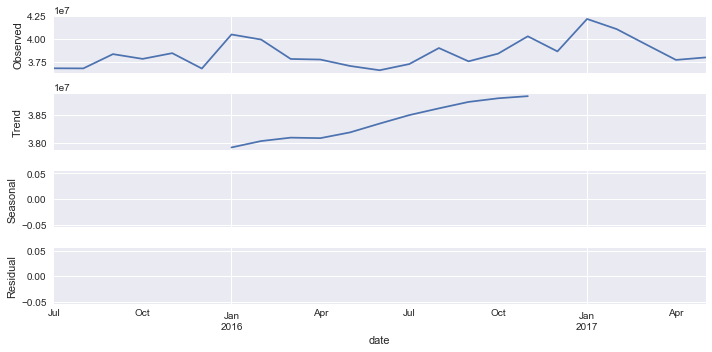

In [57]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(df['views'].resample('M').mean(),freq =12)

fig = res.plot()
fig.set_size_inches(10, 5)
plt.tight_layout()

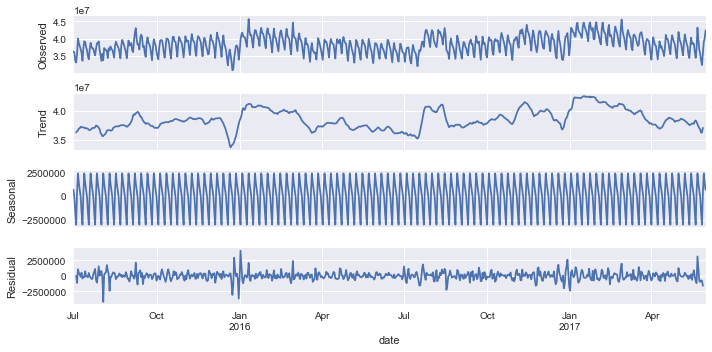

In [58]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(df[df.agent=='user']['views'].resample('D').mean(),)

fig = res.plot()
fig.set_size_inches(10, 5)
plt.tight_layout()